[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana9/Intro_keras.ipynb)

# Problema

Esta semana utilizaremos el mismo DataSet para ambas sesiones. Ésta primera sesión será para analizar un problema de fraude de modo sencillo, es decir, con un clasificador binario sencillo (que nos servirá para introducir algunas herramientas).

Podemos encontrar la base de datos en https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Los datos contienen transacciones realizadas mediante trarjeta de crédito en Septiembre del 2013 por titulares de tarjeta en Europa. Ocurrieron en 2 días en los que hubo 492 fraudes de 284,807 transacciones.

Solo contiene variables numéricas y ya pasó por un proceso de PCA para solo quedarse con las mejores características.

La columna de "Time" contiene los segundos ocurridos entre transacciones. "Amount" es la cantidad de la transacción y "Class" es la variable que tiene 1 en caso de fraude y 0 en caso contrario.



Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Leer Datos usando un método distinto al que estamos acostumbrados

In [ ]:
import numpy as np

# Get the real data from https://www.kaggle.com/mlg-ulb/creditcardfraud/

all_features = []
all_targets = []
with open('/content/drive/MyDrive/Curso-WorkingAnalyst/semana9/creditcard.csv') as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


# Preparar conjunto de validación

Lo haremos manual (es decir, no aleatorio)

In [ ]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 227846
Number of validation samples: 56961


# Analizar desbalance de los datos

In [ ]:
counts = np.bincount(train_targets[:, 0])
print(f"Number of positive samples in training data: {counts[1]} ({100 * float(counts[1]) / len(train_targets):.2f}% of total)")


Number of positive samples in training data: 417 (0.18% of total)


Asignaremos pesos de una manera balanceada (es una clase de peso "balanced" utilizada en keras). Manualmente se calcula como:

In [ ]:
total_counts = np.bincount(train_targets[:, 0])
n_samples = len(train_targets)

weight_for_0 = n_samples / (total_counts[0]*2)
weight_for_1 = n_samples / (total_counts[1]*2)

#counts = np.bincount(train_targets[:, 0])

#weight_for_0 = 1.0 / counts[0]
#weight_for_1 = 1.0 / counts[1]

print(f"{weight_for_0: .6f}")
print(f"{weight_for_1: .4f}")

 0.500917
 273.1966


Podemos ver que los pesos son practicamente una proporción de 500 a 1 aproximadamente

# Estandarizar los datos

In [ ]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

# Modelo de clasificación binaria

In [ ]:
# Módulo montado en TensorFlow para creación de redes neuronales
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,777
Trainable params: 139,777
Non-trai

# Entrenar modelo tomando en cuenta pesos para los datos


In [ ]:
# random.seed(9)
np.random.seed(1)

from tensorflow import random

random.set_seed(11)

In [ ]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
112/112 - 8s - loss: 0.4524 - fn: 53.0000 - fp: 15064.0000 - tn: 212365.0000 - tp: 364.0000 - precision: 0.0236 - recall: 0.8729 - val_loss: 0.0976 - val_fn: 10.0000 - val_fp: 905.0000 - val_tn: 55981.0000 - val_tp: 65.0000 - val_precision: 0.0670 - val_recall: 0.8667 - 8s/epoch - 70ms/step
Epoch 2/30
112/112 - 5s - loss: 0.2574 - fn: 36.0000 - fp: 8420.0000 - tn: 219009.0000 - tp: 381.0000 - precision: 0.0433 - recall: 0.9137 - val_loss: 0.0522 - val_fn: 10.0000 - val_fp: 341.0000 - val_tn: 56545.0000 - val_tp: 65.0000 - val_precision: 0.1601 - val_recall: 0.8667 - 5s/epoch - 48ms/step
Epoch 3/30
112/112 - 5s - loss: 0.3155 - fn: 37.0000 - fp: 9636.0000 - tn: 217793.0000 - tp: 380.0000 - precision: 0.0379 - recall: 0.9113 - val_loss: 0.0535 - val_fn: 15.0000 - val_fp: 148.0000 - val_tn: 56738.0000 - val_tp: 60.0000 - val_precision: 0.2885 - val_recall: 0.8000 - 5s/epoch - 47ms/step
Epoch 4/30
112/112 - 5s - loss: 0.2087 - fn: 32.0000 - fp: 9532.0000 - tn: 217897.0000 - tp: 

In [ ]:
y_train_pred = model.predict(train_features)
y_train_pred[y_train_pred < 0.5] = 0
y_train_pred[y_train_pred >= 0.5] = 1

In [ ]:
y_test_pred = model.predict(val_features)
y_test_pred[y_test_pred < 0.5] = 0
y_test_pred[y_test_pred >= 0.5] = 1

In [ ]:
len(y_test_pred[:, 0])

56961

In [ ]:
y_test_pred[:, 0].sum()

2763.0

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

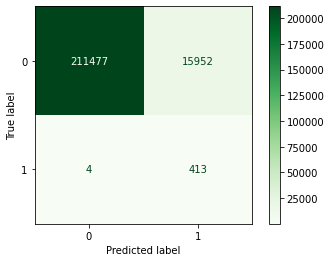

In [ ]:
ConfusionMatrixDisplay.from_predictions(train_targets, y_train_pred, cmap=plt.cm.Greens)

In [ ]:
# Recuperar "pesos" de los coeficientes en la epoca "X"
# CUIDADO AL CORRER ESTA CELDA

# model.load_weights("/content/fraud_model_at_epoch_28.h5")

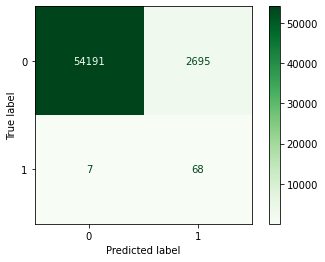

In [ ]:
ConfusionMatrixDisplay.from_predictions(val_targets, y_test_pred, cmap=plt.cm.Greens)

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
y_test_prob = model.predict(val_features)

In [ ]:
auprc = average_precision_score(val_targets, y_test_prob)
auprc

0.5694344747094825

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(train_targets, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    227429
           1       0.03      0.99      0.05       417

    accuracy                           0.93    227846
   macro avg       0.51      0.96      0.51    227846
weighted avg       1.00      0.93      0.96    227846



In [ ]:
print(classification_report(val_targets, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56886
           1       0.02      0.91      0.05        75

    accuracy                           0.95     56961
   macro avg       0.51      0.93      0.51     56961
weighted avg       1.00      0.95      0.97     56961



# Ejercicios:

* ¿Que sucedería con el modelo si no usamos el parámetro "class_weight"?

* ¿Podemos recuperar solo la mejor época de nuestro entrenamiento?

* ¿Porque la matriz de confusión no parece dar mucha luz sobre lo que ocurre?